In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import xlrd
import numbers
import matplotlib.pyplot as pl
import seaborn as sn
import datetime as dt
import matplotlib.dates as mdates
from sklearn import gaussian_process
%matplotlib inline

Leemos los sondeos obtenidos de la wikipedia (https://es.wikipedia.org/wiki/Anexo:Sondeos_de_intenci%C3%B3n_de_voto_para_las_elecciones_generales_de_Espa%C3%B1a_de_2015). Hacemos un poco de limpieza de los datos para dejar una fecha del sondeo y unificar los valores en tanto por uno. Generamos además un eje de tiempo.

In [2]:
book = xlrd.open_workbook("sondeos.xlsx")
sh = book.sheet_by_index(0)

PP = []
PSOE = []
IU = []
UPyD = []
Podemos = []
Ciudadanos = []
fecha = []

mesEsp = ['ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic']
mesEng = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

for rx in range(2,sh.nrows):
	row = sh.row_values(rx)	

	res = row[2]

	out = bytes(res, 'utf-8')
	res = out.replace(b'\xe2\x80\x93', b'-').decode('utf-8').lower()

	for i in range(12):
		res = res.replace(mesEsp[i], mesEng[i])

	res = res.replace('.', '')

	guion = res.find('-')

	if (guion != -1):
		res = res[guion+1:]

	out = res.split(' ')

	if ((len(out) > 1) and (res.find(')') == -1) ):
		if (len(out) == 2):
			res = '1 '+res

		PP.append(row[3])
		PSOE.append(row[4])
		IU.append(row[5])
		UPyD.append(row[6])
		Podemos.append(row[16])
		Ciudadanos.append(row[17])
		
		fecha.append(dt.datetime.strptime(res, "%d %b %Y").date())

partidos = [PP, PSOE, IU, UPyD, Podemos, Ciudadanos]
nSondeos = len(PP)
# Now clean the lists to transform percentages to numbers
for partido in partidos:
	for i in range(nSondeos):
		if (not isinstance(partido[i], numbers.Number)):
			findPct = partido[i].find('%')
			if (findPct != -1):
				res = 0.01*float(partido[i][0:findPct].replace(',', '.'))
				partido[i] = res
			else:
				partido[i] = 0

PP = np.asarray(PP)[::-1]
PSOE = np.asarray(PSOE)[::-1]
IU = np.asarray(IU)[::-1]
UPyD = np.asarray(UPyD)[::-1]
Podemos = np.asarray(Podemos)[::-1]
Ciudadanos = np.asarray(Ciudadanos)[::-1]
fecha = np.asarray(fecha)[::-1]
delta = np.zeros(len(fecha))
for i in range(len(fecha)):
	delta[i] = (fecha[i]-fecha[0]).days

Hacemos un dibujo con los datos. Cada valor del sondeo se muestra con puntos. Además hacemos una regresión con un Gaussian Process, que lo extrapolamos hacia adelante unos pocos meses. Las compañías de sondeos indican que sus errores de muestreo son del orden del 3% (en promedio). Si calculamos la diferencia entre los sondeos y el ajuste del GP, vemos que las diferencias están del orden del 3% absoluto.

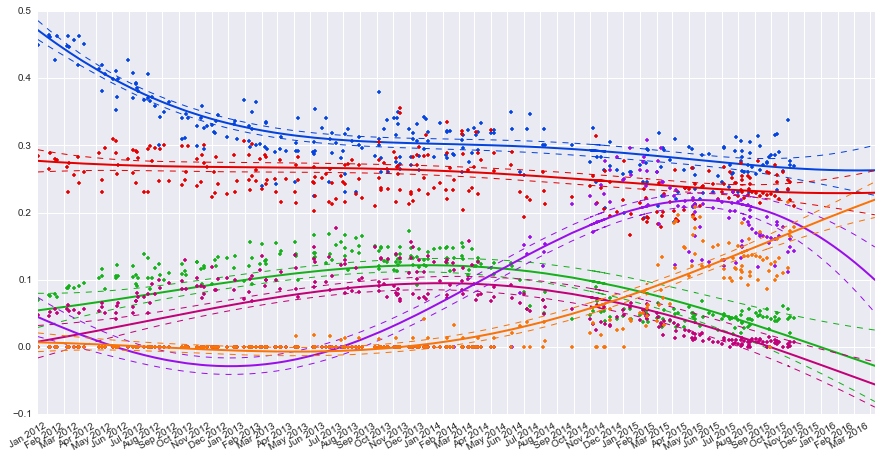

In [61]:
partidos = [PP, PSOE, IU, UPyD, Podemos, Ciudadanos]
colors = ["blue", "red", "green", "magenta", "violet", "orange"]
nombres = ["PP", "PSOE", "IU", "UPyD", "Podemos", "Ciudadanos"]

f, ax = pl.subplots(nrows=1, ncols=1, figsize=(15,8))
ax.xaxis_date() 

xu = np.unique(delta)  # get unique x values
idx = [np.where(X==x1)[0][0] for x1 in xu]
nObs = len(xu)

deltaNew = np.copy(delta)
fechaNew = np.copy(fecha)
for i in range(150):
    deltaNew = np.append(deltaNew, delta[-1] + i+1)
    fechaNew = np.append(fechaNew, fecha[-1]+dt.timedelta(days=i+1))

for i in range(6):
    ax.plot(fecha, partidos[i], '.', color=sn.xkcd_rgb[colors[i]], linewidth=2)
    y = partidos[i][idx]
    nugget = (0.03 / y)**2
    nugget[y==0] = 0.03
    gp = gaussian_process.GaussianProcess(theta0=0.1, nugget=nugget)
    gp.fit(xu[:,None], y)
    predict, variance = gp.predict(deltaNew[:,None], eval_MSE=True)
    stddev = np.sqrt(variance)

    ax.plot(fechaNew, predict, color=sn.xkcd_rgb[colors[i]], linewidth=2)
    ax.plot(fechaNew, predict+2.0*stddev, '--', color=sn.xkcd_rgb[colors[i]], linewidth=1)
    ax.plot(fechaNew, predict-2.0*stddev, '--', color=sn.xkcd_rgb[colors[i]], linewidth=1)

f.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(mdates.MonthLocator())

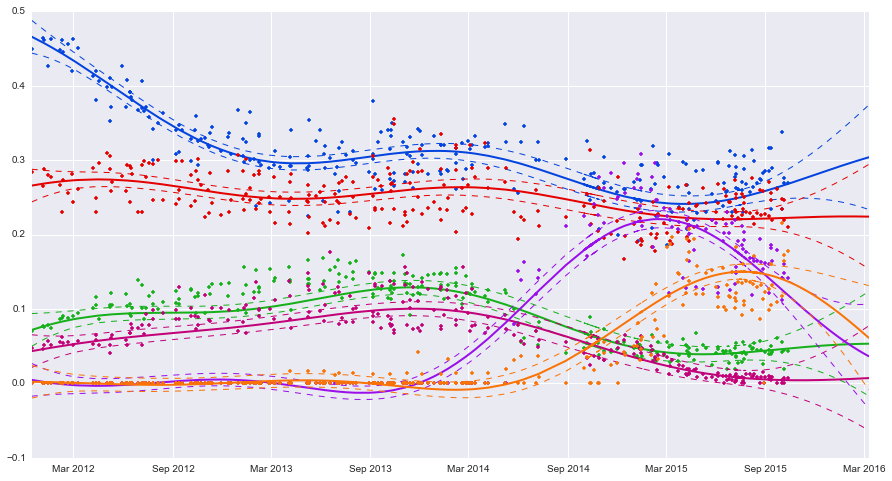

In [78]:
y = np.zeros((nObs,6))
x = np.zeros((nObs,6))
xnew = np.zeros((len(deltaNew), 6))
for i in range(6):
    x[:,i] = xu
    y[:,i] = partidos[i][idx]
    xnew[:,i] = deltaNew
gp = gaussian_process.GaussianProcess(theta0=0.1, nugget=nugget)
gp.fit(x, y)
predict, variance = gp.predict(xnew, eval_MSE=True)
stddev = np.sqrt(variance)

f, ax = pl.subplots(nrows=1, ncols=1, figsize=(15,8))
ax.xaxis_date() 
for i in range(6):
    ax.plot(fecha, partidos[i], '.', color=sn.xkcd_rgb[colors[i]], linewidth=2)
    
    ax.plot(fechaNew, predict[:,i], color=sn.xkcd_rgb[colors[i]], linewidth=2)
    ax.plot(fechaNew, predict[:,i]+2.0*stddev, '--', color=sn.xkcd_rgb[colors[i]], linewidth=1)
    ax.plot(fechaNew, predict[:,i]-2.0*stddev, '--', color=sn.xkcd_rgb[colors[i]], linewidth=1)

In [79]:
gp.theta_

array([[ 0.1]])

La extrapolación hacia adelante

PP -> 3.3%
PSOE -> 3.3%
IU -> 3.2%
UPyD -> 2.9%
Podemos -> 2.4%
Ciudadanos -> 2.3%


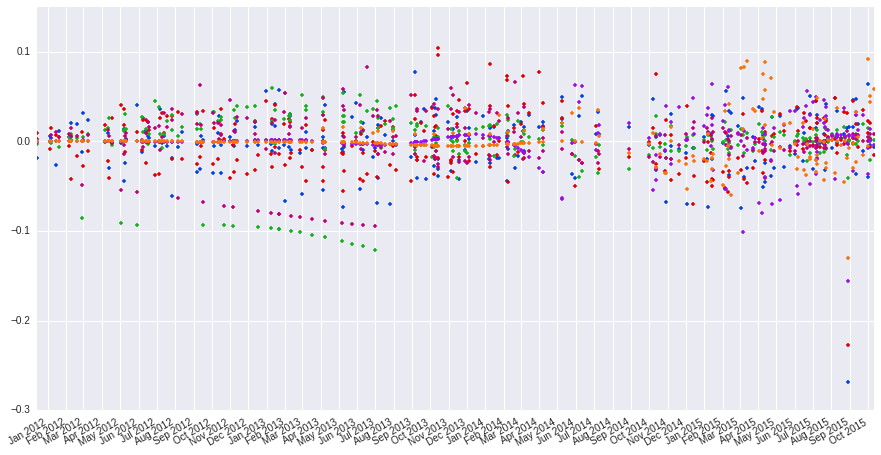

In [18]:
f, ax = pl.subplots(nrows=1, ncols=1, figsize=(15,8))
ax.xaxis_date() 

gp = ml.GaussianProcess(delta)

for i in range(6):
    gp.fit(partidos[i], 0.05)
    predict, covariance = gp.predict(delta)
    ax.plot(fecha, partidos[i] - predict, '.', color=sn.xkcd_rgb[colors[i]], linewidth=2)
    print("{0} -> {1:3.1f}%".format(nombres[i], 100.0*np.std(partidos[i] - predict)))

f.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(mdates.MonthLocator())